<a href="https://colab.research.google.com/github/yurimenzl/smi_test_position/blob/main/smi_teste_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Core libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

# Splitting data into training/testing
from sklearn.model_selection import train_test_split

In [8]:
# Loading the dataset using a csv file
df = pd.read_csv("FC_Mixer_MO.csv")

In [9]:
# Example of data present in the dataset
df.head()

,site,division,category,line,model_name,recipe_group,uniqueid,product_code,model_complete,char_name,char_time,char_value
0,Amera,HomeEssentials,FabricConditioner,MX-FB-03,MX-FB-Visc_pred_v0.14,UNDEFINED,44168,None,COMPLETE,non_value_operating_time,2023-02-11 10:19:25,3560.0
1,Amera,HomeEssentials,FabricConditioner,MX-FB-03,MX-FB-Visc_pred_v0.14,UNDEFINED,44168,None,COMPLETE,non_value_operating_time,2023-02-11 20:49:30,300.0
2,Amera,HomeEssentials,FabricConditioner,MX-FB-03,MX-FB-Visc_pred_v0.14,UNDEFINED,44168,None,COMPLETE,non_value_operating_time,2023-02-12 04:28:05,190.0
3,Amera,HomeEssentials,FabricConditioner,MX-FB-03,MX-FB-Visc_pred_v0.14,UNDEFINED,44168,None,COMPLETE,non_value_operating_time,2023-02-12 07:41:10,140.0
4,Amera,HomeEssentials,FabricConditioner,MX-FB-03,MX-FB-Visc_pred_v0.14,UNDEFINED,44168,None,COMPLETE,non_value_operating_time,2023-02-12 15:19:00,640.0


In [10]:
# Checking unique values in each column. In this step we'll remove all columns that does not contributes in the analysis because they only have 1 value
df.nunique()

site                 1
division             1
category             1
line                 1
model_name           1
recipe_group         1
uniqueid           164
product_code         1
model_complete       2
char_name           10
char_time          619
char_value        1154
dtype: int64

In [11]:
# According to df.nunique(), columns site, division, category, line, model_name, recipe_group, product_code
# only have 1 value, that's why we'll remove these columns for our working dataset
df_work = df[['uniqueid', 'model_complete', 'char_name', 'char_time', 'char_value']]

# Showing the removal of columns
df_work.head()

,uniqueid,model_complete,char_name,char_time,char_value
0,44168,COMPLETE,non_value_operating_time,2023-02-11 10:19:25,3560.0
1,44168,COMPLETE,non_value_operating_time,2023-02-11 20:49:30,300.0
2,44168,COMPLETE,non_value_operating_time,2023-02-12 04:28:05,190.0
3,44168,COMPLETE,non_value_operating_time,2023-02-12 07:41:10,140.0
4,44168,COMPLETE,non_value_operating_time,2023-02-12 15:19:00,640.0


In [12]:
# With this step, we'll check if any column have missing values and the dtype of each column
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646 entries, 0 to 3645
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uniqueid        3646 non-null   int64  
 1   model_complete  3646 non-null   object 
 2   char_name       3646 non-null   object 
 3   char_time       3646 non-null   object 
 4   char_value      3646 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 142.5+ KB


In [13]:
# In df.info() we could saw the columns model_complete, char_name and char_time are objects, so we'll change with a suitable data type, which is a string
df_work = df_work.astype({'model_complete': 'string', 'char_name': 'string', 'char_time': 'string'})

# Checking if out operation was succeed
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3646 entries, 0 to 3645
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uniqueid        3646 non-null   int64  
 1   model_complete  3646 non-null   string 
 2   char_name       3646 non-null   string 
 3   char_time       3646 non-null   string 
 4   char_value      3646 non-null   float64
dtypes: float64(1), int64(1), string(3)
memory usage: 142.5 KB


In [14]:
# Here, We'll drop duplicates using char_name (phases and metrics), char_time (timestamp of when the data was captured) and char_value (value for the tuple).
# We did this because we noticed in a visual analysis that several batches had repeated values ​​and, therefore, could create a bias in subsequent analyses.
df_work = df_work.drop_duplicates(['char_name', 'char_time', 'char_value'])

In [15]:
# Checking the remanscent values
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 0 to 3645
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uniqueid        1520 non-null   int64  
 1   model_complete  1520 non-null   string 
 2   char_name       1520 non-null   string 
 3   char_time       1520 non-null   string 
 4   char_value      1520 non-null   float64
dtypes: float64(1), int64(1), string(3)
memory usage: 71.2 KB


In [16]:
# Before this step, we focused in identify duplicates values and remove of irrelevant columns, but We didn't have, yet, data that can bee properly analyzed.
# To fix this issue, we did used a function called pivot_table from pandas library to change char_value column (which have all phases and metrics that we'll
# use to analyze the dataset) and convert this column in a workable dataframe
df_pivot_table = df_work.pivot_table(values='char_value', index='uniqueid', columns='char_name', aggfunc="mean")

In [17]:
# The original column names are very hard to understand, so we'll rename all columns with a suitable name
new_columns = {
    'phase_1.Inicio.duration': 'start_duration',
    'phase_2.Medicion.duration': 'measure_duration',
    'phase_3.Recirculacion.Densidad_max': 'density',
    'phase_3.Recirculacion.Peso_avg': 'average_weight',
    'phase_3.Recirculacion.Presion_avg': 'average_pressure',
    'phase_3.Recirculacion.Presion_max': 'maximum_pressure',
    'phase_3.Recirculacion.Visco_max': 'maximum_viscosity',
    'phase_3.Recirculacion.duration': 'recirculation_duration',
}

df_pivot_table = df_pivot_table.rename(columns=new_columns)

# Checking the operation realized and see data types of each column.
df_pivot_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 44168 to 47268
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   non_value_operating_time  118 non-null    float64
 1   start_duration            115 non-null    float64
 2   measure_duration          104 non-null    float64
 3   density                   106 non-null    float64
 4   average_weight            106 non-null    float64
 5   average_pressure          106 non-null    float64
 6   maximum_pressure          106 non-null    float64
 7   maximum_viscosity         106 non-null    float64
 8   recirculation_duration    106 non-null    float64
 9   total_duration            118 non-null    float64
dtypes: float64(10)
memory usage: 10.1 KB


In [18]:
# In previous step, we could see that several columns have missing values, so we'll fill this values with a mean value of respective column

df_pivot_table.fillna(df_pivot_table.mean())

char_name,non_value_operating_time,start_duration,measure_duration,density,average_weight,average_pressure,maximum_pressure,maximum_viscosity,recirculation_duration,total_duration
uniqueid,,,,,,,,,,
44168,2511.666667,123.076923,8841.153846,55142.891667,13136.436319,1.325082,2.560432,1292.827154,9726.666667,17025.769231
44307,5640.000000,1555.000000,13792.500000,62080.046000,15767.397500,1.590551,3.126447,825.000000,5972.500000,21320.000000
44339,215.000000,10.000000,79175.000000,57672.496000,194.223500,1.041677,3.146355,0.000000,12365.000000,91550.000000
44348,185.000000,45.000000,70160.000000,58872.270000,58810.790000,2.876662,2.879051,0.000000,35.000000,70240.000000
44453,1020.000000,65.000000,23257.500000,38118.948400,4293.057350,0.958474,1.787979,0.000000,6160.000000,29482.500000
...,...,...,...,...,...,...,...,...,...,...
47156,3485.000000,102.500000,12350.000000,57055.537000,56880.980500,3.152164,3.155119,0.000000,92.500000,12545.000000
47184,2585.000000,135.000000,18322.500000,58537.660000,58503.258000,3.036868,3.038195,0.000000,20.000000,18467.500000
47204,150.000000,120.000000,11535.000000,63097.953000,27788.645000,1.860552,2.986111,878.000000,3290.000000,14945.000000


In [20]:
# Describing several attributes from our dataset. As we can see, the columns have discrepancies ranges comparing the columns,
# so we'll normalize all columns to have a similar range of values
df_pivot_table.describe()

char_name,non_value_operating_time,start_duration,measure_duration,density,average_weight,average_pressure,maximum_pressure,maximum_viscosity,recirculation_duration,total_duration
count,118.000000,115.000000,104.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,118.000000
mean,3385.141243,171.439799,16419.722633,57299.754825,26422.893776,1.843625,2.796782,437.084098,7324.921384,21715.176010
std,6929.334574,282.035515,18230.565647,16627.626115,20820.920752,0.784096,0.641174,428.494441,16426.829728,26484.961826
min,5.000000,10.000000,25.000000,-9214.445000,-11508.949000,0.220505,0.291976,0.000000,10.000000,185.000000
25%,172.500000,77.500000,7290.000000,57501.375500,7956.056700,1.305175,2.857350,0.000000,936.875000,10871.250000
50%,597.500000,107.500000,10240.000000,61101.548750,22631.921500,1.729442,3.025904,422.750000,3580.000000,14847.500000
75%,3448.125000,130.000000,17581.875000,62812.641250,40767.508750,2.369733,3.127894,800.000000,6351.875000,22445.000000
max,48300.000000,1670.000000,112475.000000,132247.750000,60461.570000,3.228009,3.269676,2281.717000,146435.000000,229025.000000


In [21]:
# Normalize values in every column using the log technique and replacing missing values / infinite values with 0,
# because we could analyze that several metrics had 0 as value and the code were considering as missing values.
df_norm_log = np.log(df_pivot_table)
df_norm_log = df_norm_log.replace([np.nan, -np.inf], 0)

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [22]:
# Describing the new normalized dataset
df_norm_log.describe()

char_name,non_value_operating_time,start_duration,measure_duration,density,average_weight,average_pressure,maximum_pressure,maximum_viscosity,recirculation_duration,total_duration
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,6.706223,4.507449,8.187534,9.537568,8.212384,0.445441,0.873694,3.400868,6.713975,9.565291
std,1.732584,1.183001,3.178410,3.684991,3.813584,0.532063,0.492237,3.310247,3.083300,0.983064
min,1.609438,0.000000,0.000000,0.000000,0.000000,-1.511835,-1.231085,0.000000,0.000000,5.220356
25%,5.150088,4.317488,8.782626,10.938586,8.412393,0.119043,0.983582,0.000000,4.552872,9.293871
50%,6.392325,4.653960,9.166518,11.011625,9.870103,0.481922,1.093972,5.916194,8.066967,9.605565
75%,8.145583,4.867534,9.532152,11.044699,10.524555,0.786352,1.137579,6.684612,8.718104,10.018811
max,10.785187,7.420579,11.630486,11.792432,11.009763,1.171866,1.184691,7.732684,11.894337,12.341586


Com essa etapa, nós conseguimos limpar os dados originais das colunas que não possuem nenhuma relevância para ser analisada, visto que só apresentaram 1 valor e, também, identificamos os valores ausentes e substituimos com o valor médio da respectiva coluna. Por fim, removemos os valores duplicados e renomeamos as colunas para um melhor entendimento, reduzindo os registros iniciais de 3646 para 118.

Fim Task 1

Inicio da Task 2

In [25]:
# Takes in a dataframe, finds the most strongly correlated variables with the
# density and returns training and testing datasets
def format_data(df, num_features = 2):
    # Targets are density values
    labels = df['density']

    # Find correlations with the density, using spearman method because data are not normal
    most_correlated = df.corr(method="spearman").abs()['density'].sort_values(ascending=False)

    # Maintain the most correlation features with Grade
    most_correlated = most_correlated[:num_features]

    df = df.loc[:, most_correlated.index]

    # Split into training/testing sets with 20% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels,
                                                        test_size = 0.20,
                                                        random_state=42)

    return X_train, X_test, y_train, y_test

columns = [
      'start_duration',
      'density',
      'measure_duration',
      'average_weight',
      'average_pressure',
      'maximum_pressure',
      'maximum_viscosity',
      'recirculation_duration',
    ]

# Creating our input matrix (X_train and X_test) and our target array (y_train, y_test which is density values)
X_train_most, X_test_most, y_train_most, y_test_most = format_data(df_norm_log[columns])

In [26]:
# Describing some useful information and identifying that are most strongly correlated variable is recirculation_duration.
X_train_most.describe()

char_name,density,recirculation_duration
count,94.000000,94.000000
mean,9.542255,6.632386
std,3.697095,3.050044
min,0.000000,0.000000
25%,10.939682,4.418322
50%,11.011625,7.976737
75%,11.044050,8.639188
max,11.792432,11.894337


<Axes: xlabel='char_name', ylabel='char_name'>

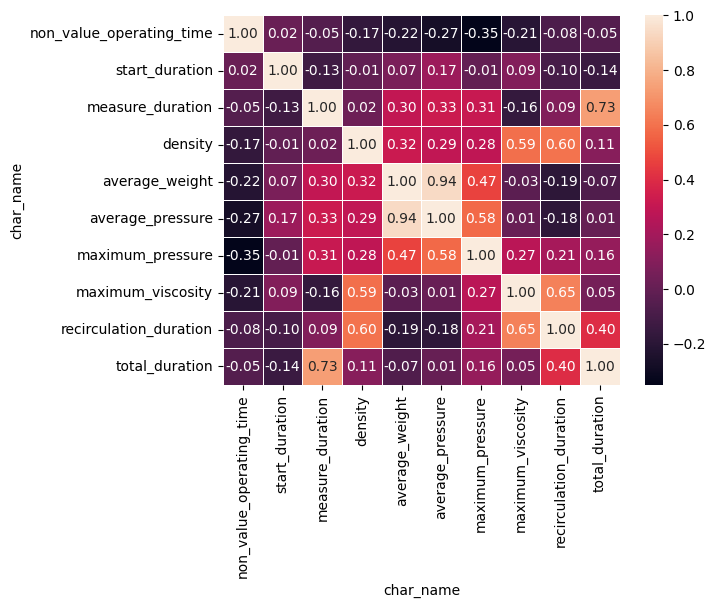

In [27]:
# Here, we can check if recirculation_time is the most strongly correlated variable with density,
# and we corroborates the value because they have a correlation of 0.60, which is the highest possible
# considering density as target
correlation = df_norm_log.corr(method="spearman")

# plot for correlation matrix
plot = sns.heatmap(correlation, annot = True, fmt=".2f", linewidths=.6)
plot

In [28]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'RidgeCV',
                      'Random Forest', 'Extra Trees',
                       'XGBoost', 'Gradient Boosted'
                       ]

    # Instantiate the models
    model1 = LinearRegression()
    model2 = RidgeCV()
    model3 = RandomForestRegressor(n_estimators=100, random_state=42)
    model4 = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model5 = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    model6 = GradientBoostingRegressor(n_estimators=100, random_state=42)

    # Dataframe for results
    X_train = X_train.drop(['density'],axis=1)
    X_test = X_test.drop(['density'],axis=1)

    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(model_name_list[i])

        print('------Train-------')
        # Metrics
        mae = np.mean(abs(model.predict(X_train) - y_train))
        rmse = np.sqrt(np.mean((model.predict(X_train) - y_train) ** 2))
        score = model.score(X_train,y_train)
        print("Score: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}    |".format(score, mae,  rmse))

        print('-------Test-------')
        score = model.score(X_test,y_test)
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        print("Score: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}    |".format(score, mae,  rmse))
        model_name = model_name_list[i]
        print('------------------')
# We are using 3 metrics to evaluate our ML model. RMSE, MAE and score (r^2) in both training and test dataset
evaluate(X_train_most, X_test_most, y_train_most, y_test_most)

Linear Regression
------Train-------
Score: 0.5475, MAE: 1.7877, RMSE: 2.4738    |
-------Test-------
Score: 0.7026, MAE: 1.3377, RMSE: 1.9838    |
------------------
RidgeCV
------Train-------
Score: 0.5475, MAE: 1.7877, RMSE: 2.4738    |
-------Test-------
Score: 0.7026, MAE: 1.3377, RMSE: 1.9838    |
------------------
Random Forest
------Train-------
Score: 0.9133, MAE: 0.2917, RMSE: 1.0827    |
-------Test-------
Score: 0.7633, MAE: 0.6232, RMSE: 1.7699    |
------------------
Extra Trees
------Train-------
Score: 0.9371, MAE: 0.1559, RMSE: 0.9220    |
-------Test-------
Score: 0.7663, MAE: 0.6516, RMSE: 1.7586    |
------------------
XGBoost
------Train-------
Score: 0.9371, MAE: 0.1576, RMSE: 0.9220    |
-------Test-------
Score: 0.8043, MAE: 0.5410, RMSE: 1.6094    |
------------------
Gradient Boosted
------Train-------
Score: 0.9369, MAE: 0.1859, RMSE: 0.9236    |
-------Test-------
Score: 0.7611, MAE: 0.6282, RMSE: 1.7781    |
------------------


In [492]:
# We'll choose the XGBoost Regressor because this model could predict with
# a high accuracy the test set and presented low values for RMSE and MAE
from sklearn.model_selection import LeaveOneOut, cross_val_score

y = df_norm_log['density']
X = df_norm_log.drop(['density'],axis=1)

# Create a linear regression model
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Create a LeaveOneOut cross-validator
loo = LeaveOneOut()

# Use cross_val_score for the dataset with the model and LOOCV
# This will return the scores for each iteration of LOOCV
scores = cross_val_score(model, X, y, cv=loo, scoring='neg_root_mean_squared_error')

rmse_scores = -scores  # Invert the sign of the scores

scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_absolute_error')

mean_absolute_scores = -scores

scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')

mean_squared_scores = -scores


# Print the mean RMSE / MAE / MSE over all LOOCV iterations
print("Mean RMSE Scoring:", rmse_scores.mean())
print("Mean MAE Scoring:", mean_absolute_scores.mean())
print("Mean MSE Scoring:", mean_squared_scores.mean())



Mean RMSE Scoring: 0.18252006661588885
Mean MAE Scoring: 0.18252006661588885
Mean MSE Scoring: 0.707138929499879


Fim Task 2

Modelo Escolhido XGBoost Regressor pois foi qual apresentou melhor score nos dados de teste. Ao executar as métricas de erro, todos os valores encontrados foram baixos, mostrando que o modelo consegue predizer bem a densidade quando é considerada somente a variável mais fortemente correlacionada.

Inicio Task 3

Em minha análise visual, observei que as medições tidas como completas apresentavam 10 passos e, quando não era possível completar esses 10 passos, o algoritmo tentava novamente e, mesmo não conseguindo obter as 10 informações sequenciais, ele considerava o modelo como Completo. Visto isso, como tenho que criar um dashboard com alguns insights de Batch Cycle Time, considerei somente os registros que apresentaram os 10 registros sequenciais para plotar os gráficos que achei que trariam maiores insights para a atividade.

In [29]:
contagem_valores = df_work['uniqueid'].value_counts()

# Identifica os valores que aparecem mais de 10 vezes
valores_igual_10_vezes = contagem_valores[contagem_valores == 10].index

# Limpa a coluna 'coluna_limpar' para os valores identificados
df_work_full_cycle = df_work.loc[df_work['uniqueid'].isin(valores_igual_10_vezes)]

# Exemplo de exibição do DataFrame resultante
df_work_full_cycle.describe()

,uniqueid,char_value
count,670.000000,670.000000
mean,46011.925373,13519.631841
std,786.971629,23835.843105
min,44339.000000,-11508.949000
25%,45415.000000,3.250145
50%,45920.000000,800.000000
75%,46822.000000,14053.750000
max,47268.000000,229025.000000


In [35]:
# Nesse gráfico, analisei o tempo que cada batch demorou para ser executado nas 3 fases principais, Inicio, Medição e Recirculação.
df_batch_analysis = df_work_full_cycle[['uniqueid', 'char_name', 'char_value']]

columns = [
    'non_value_operating_time',
    'total_duration',
    'phase_1.Inicio.duration',
    'phase_2.Medicion.duration',
    'phase_3.Recirculacion.duration'
]

# Filtrando somente as colunas que julguei serem relevantes para essa análise relacionadas ao tempo
df_batch_analysis = df_batch_analysis[df_batch_analysis['char_name'].isin(columns)]

# Segundo o guia encaminhado, as colunas non_value_operating_time e total_duration precisariam
# serem identificadas como fase 0 e com o nome da fase de global
df_batch_analysis = df_batch_analysis.replace(['non_value_operating_time', 'total_duration'], 'phase_0.global.duration')

# Criei agora o dataframe para ser usado na visualização dos gráficos
df_treated = pd.DataFrame()

# Separando nas colunas phase_number e phase_name com base na coluna char_name
df_treated[['phase_number', 'phase_name', 'duration']] = df_batch_analysis['char_name'].str.split('.', expand=True)

# Convertendo e criando as colunas duration_in_seconds e duration_in_minutes
df_treated['duration_in_seconds'] = df_batch_analysis['char_value']
df_treated['duration_in_minutes'] = df_batch_analysis['char_value'] / 60.0
df_treated = df_treated.replace('phase_', '', regex=True)

# Alterando os data types para os tipos corretos
df_treated = df_treated.astype({'phase_number': 'int', 'phase_name': 'string'})

# Resetando os indexes
df_treated = df_treated.reset_index()

# Removendo a coluna duration que foi um dos valores obtidos quando foi separado o campo char_name
df_treated = df_treated.drop(['duration', 'index'], axis=1)

df_treated.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   phase_number         335 non-null    int64  
 1   phase_name           335 non-null    string 
 2   duration_in_seconds  335 non-null    float64
 3   duration_in_minutes  335 non-null    float64
dtypes: float64(2), int64(1), string(1)
memory usage: 10.6 KB


In [36]:
# Mostrando o novo dataframe criado
df_treated.head()

,phase_number,phase_name,duration_in_seconds,duration_in_minutes
0,0,global,215.0,3.583333
1,1,Inicio,10.0,0.166667
2,2,Medicion,79175.0,1319.583333
3,3,Recirculacion,12365.0,206.083333
4,0,global,91550.0,1525.833333


In [37]:
df_treated.describe()

,phase_number,duration_in_seconds,duration_in_minutes
count,335.000000,335.000000,335.000000
mean,1.200000,9972.388060,166.206468
std,1.167935,21319.819726,355.330329
min,0.000000,5.000000,0.083333
25%,0.000000,135.000000,2.250000
50%,1.000000,3645.000000,60.750000
75%,2.000000,11025.000000,183.750000
max,3.000000,229025.000000,3817.083333


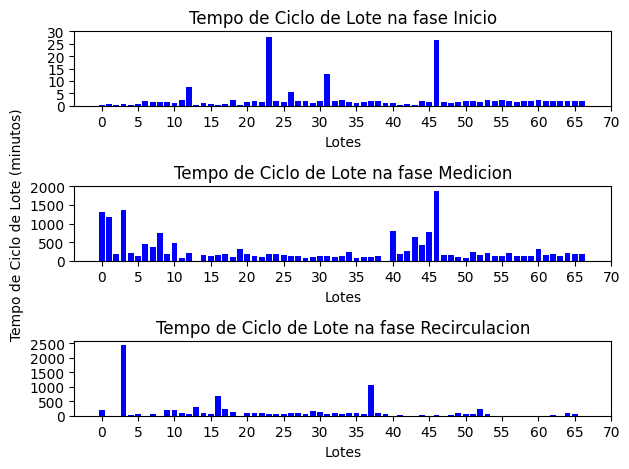

In [39]:
# Definindo nossos dataframes para cada Fase
df_inicio = df_treated[df_treated['phase_name'] == 'Inicio']
df_medicion = df_treated[df_treated['phase_name'] == 'Medicion']
df_recirculacion = df_treated[df_treated['phase_name'] == 'Recirculacion']

# Dados do batch cycle time (tempo de ciclo de lote)
batch_cycle_times = df_inicio['duration_in_minutes']

# Definindo o range X
x_range = range(0, 67, 1)

# Criar um gráfico de barras
plt.subplot(311)
plt.bar(x_range, batch_cycle_times, color='blue')
plt.yticks(np.arange(0, 31, 5))
plt.xticks(np.arange(0, 71, step=5))

# Adicionar rótulos e título
plt.title('Tempo de Ciclo de Lote na fase Inicio')
plt.xlabel('Lotes')

# Dados do batch cycle time (tempo de ciclo de lote)
batch_cycle_times = df_medicion['duration_in_minutes']

# Criar um gráfico de barras
plt.subplot(312)
plt.bar(x_range, batch_cycle_times, color='blue')
plt.yticks(np.arange(0, 2001, 500))
plt.xticks(np.arange(0, 71, step=5))

# Adicionar rótulos e título
plt.ylabel('Tempo de Ciclo de Lote (minutos)')
plt.xlabel('Lotes')
plt.title('Tempo de Ciclo de Lote na fase Medicion')

# Dados do batch cycle time (tempo de ciclo de lote)
batch_cycle_times = df_recirculacion['duration_in_minutes']

# Criar um gráfico de barras
plt.subplot(313)
plt.bar(x_range, batch_cycle_times, color='blue')
plt.yticks(np.arange(0, 2501, 500))
plt.xticks(np.arange(0, 71, step=5))

# Adicionar rótulos e título
plt.xlabel('Lotes')
plt.title('Tempo de Ciclo de Lote na fase Recirculacion')

# Exibir o gráfico
plt.tight_layout()

plt.show()

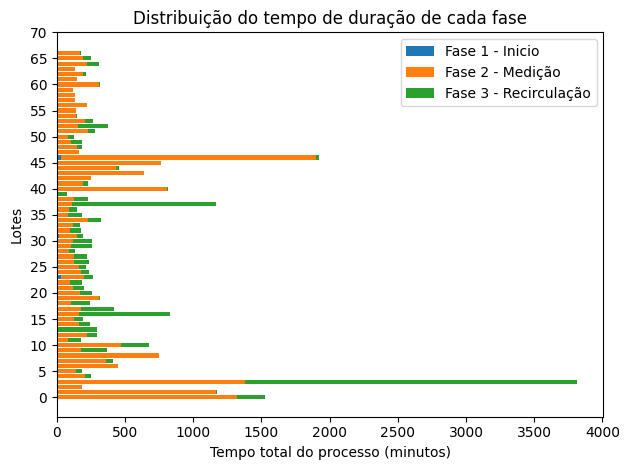

In [41]:
# Esse gráfico será responsável para mostrar a porcentagem de cada fase em todos os batchs
batch_cycle_times_1 = df_recirculacion['duration_in_minutes']
batch_cycle_times_2 = df_medicion['duration_in_minutes']
batch_cycle_times_3 = df_inicio['duration_in_minutes']

y = np.array([batch_cycle_times_3,
              batch_cycle_times_2,
              batch_cycle_times_1
              ])

for i in range(y.shape[0]):
  plt.barh(x_range, y[i], height=0.8, left = np.sum(y[:i], axis = 0))

plt.title("Distribuição do tempo de duração de cada fase")
plt.xlabel('Tempo total do processo (minutos)')
plt.ylabel('Lotes')
plt.yticks(np.arange(0, 71, step=5))
plt.legend(['Fase 1 - Inicio', 'Fase 2 - Medição', 'Fase 3 - Recirculação'])
plt.tight_layout()
plt.show()


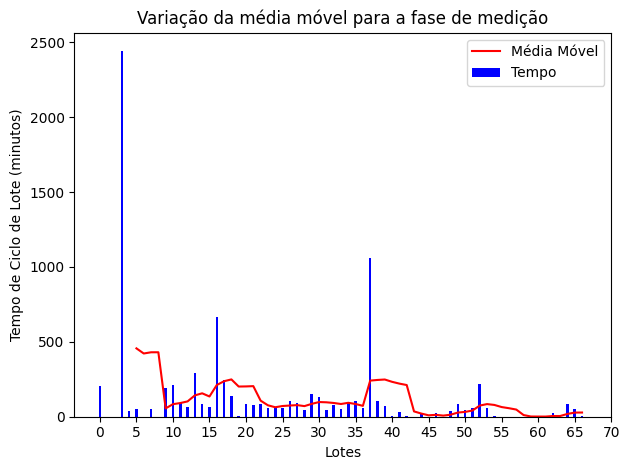

In [44]:
# Gráfico da média temporal da fase de recirculação, que foi a mais fortemente correlacionada com a densidade
recirculacion_mean = df_recirculacion['duration_in_minutes'].rolling(6).mean()

plt.bar(x_range, batch_cycle_times, width=0.35, color='blue')
plt.plot(x_range, recirculacion_mean, color="r")
plt.xticks(np.arange(0, 71, step=5))
plt.yticks(np.arange(0, 2501, 500))


plt.title("Variação da média móvel para a fase de medição")
plt.ylabel('Tempo de Ciclo de Lote (minutos)')
plt.xlabel('Lotes')
plt.tight_layout()
plt.legend(['Média Móvel', 'Tempo'])
plt.show()